# Analyzing the gradients of the SHT

## Setup

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn

from torch_harmonics.quadrature import legendre_gauss_weights, clenshaw_curtiss_weights
from torch_harmonics.legendre import legpoly, clm
from torch_harmonics import RealSHT, InverseRealSHT

## Problem setting

We consider the simple problem of fitting the spectral coefficients $\theta$ such that

$$
\begin{align}
\mathcal{L}
&= ||\mathop{\mathrm{ISHT}}[\theta] - u^*||^2_{S^2} \\
&\approx \sum_j \omega_j (\mathop{\mathrm{ISHT}}[\theta](x_j) - u^*(x_j))^2 \\
&= (S \, \theta - u^*)^T \mathop{\mathrm{diag}}(\omega) \, (S \, \theta - u^*) \\
&= L
\end{align}
$$

is minimized.

The Vandermonde matrix $S$, which is characterized by $\mathop{\mathrm{ISHT}}[\theta] = S \theta$ realizes the action of the discrete SHT.

The necessary condition for a minimizer of $L$ is

$$
\begin{align}
& \nabla_\theta L = S^T \mathop{\mathrm{diag}}(\omega) \, (S \, \theta - u^*) = 0 \\
\Leftrightarrow \quad & S^T \mathop{\mathrm{diag}}(\omega) \, S \; \theta = S^T \mathop{\mathrm{diag}}(\omega) \, u^*.
\end{align}
$$

On the Gaussian grid, 

In [20]:
nlat = 256
nlon = 2*nlat
grid = "equiangular"

# for quadrature and plotting
if grid == "legendre-gauss":
    lmax = mmax = nlat
    xq, wq = legendre_gauss_weights(nlat)
elif grid =="equiangular":
    lmax = mmax = nlat//2
    xq, wq = clenshaw_curtiss_weights(nlat)

sht = RealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)
isht = InverseRealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)

lat = np.arccos(xq)
omega = torch.pi * torch.from_numpy(wq).float() / nlat
omega = omega.reshape(-1, 1)

nlon*omega.sum()

tensor(12.5664)

In [21]:
# !wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

# import imageio.v3 as iio

# img = iio.imread('./data/mola_topo.jpg')
# #convert to grayscale
# data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# # interpolate onto 512x1024 grid:
# data = nn.functional.interpolate(torch.from_numpy(data).unsqueeze(0).unsqueeze(0), size=(nlat,nlon)).squeeze()

In [22]:
import h5py

f = h5py.File("/d0/amunozj/AFT/2022/12/AFTmap_20221221_1200.h5", 'r')

# f['maps']['aftmap'][...]
data = nn.functional.interpolate(torch.from_numpy(f['maps']['aftmap'][...]).unsqueeze(0).unsqueeze(0), size=(nlat,nlon)).squeeze()
data.shape

torch.Size([256, 512])

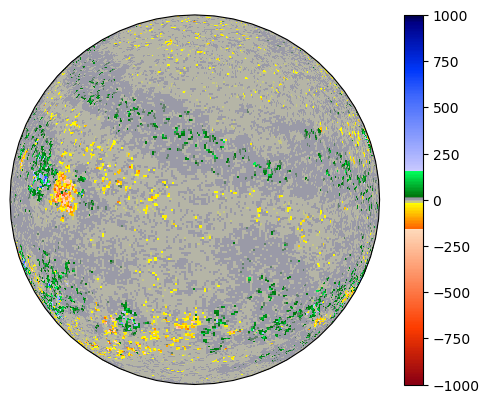

In [23]:
import matplotlib.pyplot as plt
from sunpy.visualization.colormaps import cm
from plotting import plot_sphere

cmap = 'hmimag'
vmax = 1000

plot_sphere(data, cmap=cmap, colorbar=True, vmin=-vmax, vmax=vmax)

In [24]:
lr = 1.0
theta = nn.Parameter(torch.randn(lmax, lmax, dtype=torch.complex64))
optim = torch.optim.SGD([theta], lr=lr)

for iter in range(40):
    optim.zero_grad(set_to_none=True)
    loss = torch.sum(0.5*omega*(isht(theta) - data)**2)
    loss.backward()

    # action of the Hessian
    with torch.no_grad():
        for m in range(1,mmax):
            theta.grad[:,m].mul_(0.5)

    optim.step()

    print(f"iter: {iter}, loss: {loss}")

# for iter in range(40):
#     optim.zero_grad(set_to_none=True)
#     loss = torch.sum(0.5*omega*(isht(theta) - data)**2)
#     loss.backward()

#     # action of the Hessian
#     with torch.no_grad():
#         for m in range(1,mmax):
#             theta.grad[:,m].mul_(0.5)
    
#     with torch.no_grad():
#         theta.add_(theta.grad, alpha=-lr)

#     print(f"iter: {iter}, loss: {loss}")

iter: 0, loss: 17948.929305439862
iter: 1, loss: 3231.07375508078
iter: 2, loss: 3231.07374179516
iter: 3, loss: 3231.073750926742
iter: 4, loss: 3231.0737556923395
iter: 5, loss: 3231.0737743535874
iter: 6, loss: 3231.073748487632
iter: 7, loss: 3231.073772533804
iter: 8, loss: 3231.0737562950644
iter: 9, loss: 3231.0737683149728
iter: 10, loss: 3231.0737460468836


iter: 11, loss: 3231.07378337149
iter: 12, loss: 3231.0737699799383
iter: 13, loss: 3231.0737563863354
iter: 14, loss: 3231.0737920264983
iter: 15, loss: 3231.073745300868
iter: 16, loss: 3231.0737573180704
iter: 17, loss: 3231.0737667644166
iter: 18, loss: 3231.073756850818
iter: 19, loss: 3231.0737514068537
iter: 20, loss: 3231.07378443019
iter: 21, loss: 3231.073776988286
iter: 22, loss: 3231.073777272442
iter: 23, loss: 3231.0737580697432
iter: 24, loss: 3231.073761476559
iter: 25, loss: 3231.0737667973817
iter: 26, loss: 3231.073764310035
iter: 27, loss: 3231.0737598391916
iter: 28, loss: 3231.0737647130923
iter: 29, loss: 3231.0737726130683
iter: 30, loss: 3231.0737582940264
iter: 31, loss: 3231.073779034434
iter: 32, loss: 3231.0737617734667
iter: 33, loss: 3231.073761668495
iter: 34, loss: 3231.0737590238623
iter: 35, loss: 3231.0737632576065
iter: 36, loss: 3231.0737669383834
iter: 37, loss: 3231.073773017151
iter: 38, loss: 3231.0737522418685
iter: 39, loss: 3231.073764585632

what's the best possible loss? $\theta^* = (S^T \mathop{\mathrm{diag}}(\omega) \, S)^{-1} S^T \mathop{\mathrm{diag}}(\omega) u^* = \mathop{\mathrm{SHT}}[u^*]$ gives us the global minimizer for this problem.

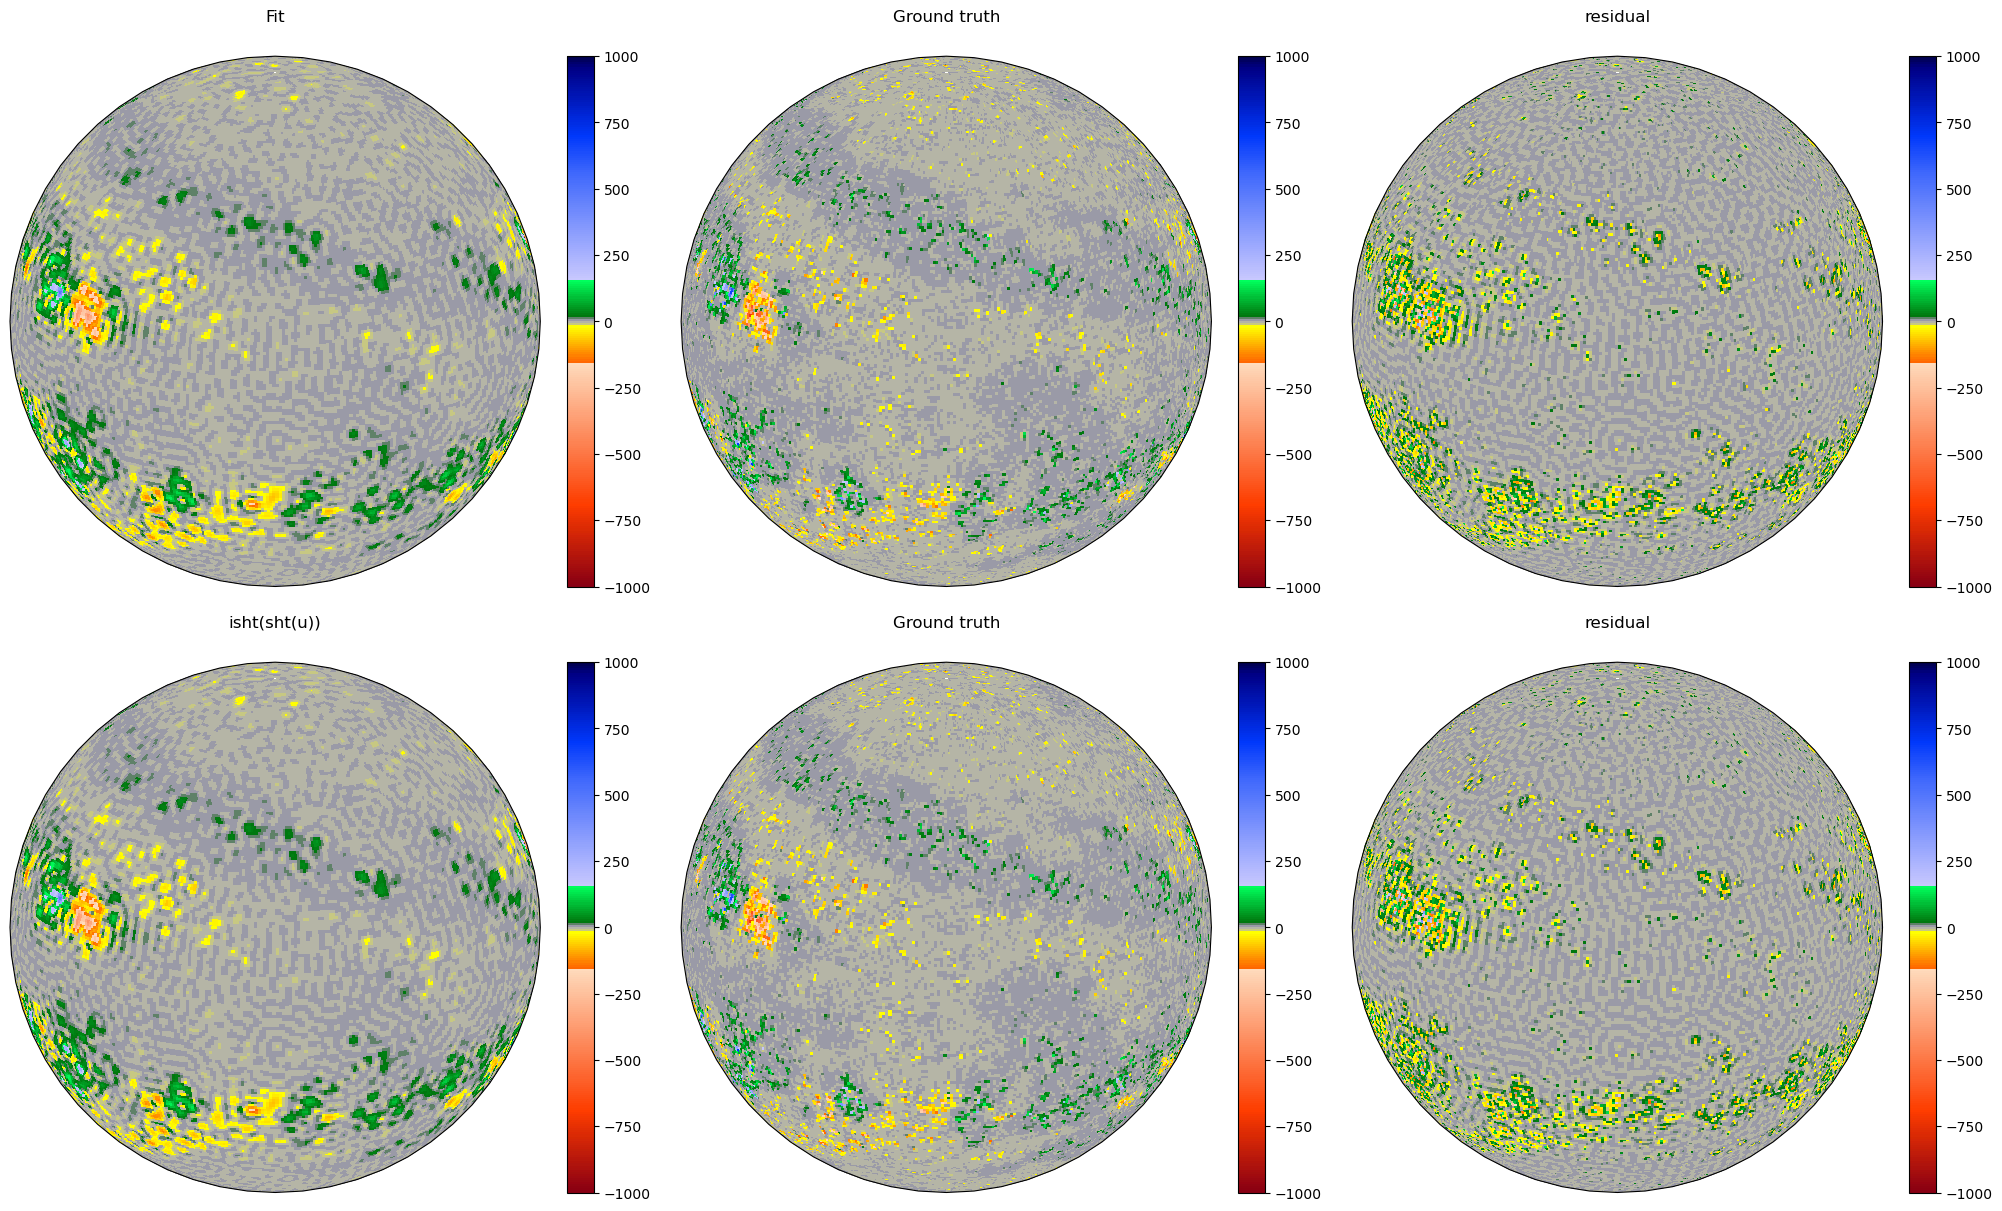

In [25]:
fig = plt.figure(layout='constrained', figsize=(20, 12))
subfigs = fig.subfigures(2, 3)

# spectral fitting
plot_sphere(isht(theta).detach(), fig=subfigs[0,0], cmap=cmap, colorbar=True, title="Fit", vmin=-vmax, vmax=vmax)
plot_sphere(data, fig=subfigs[0,1], cmap=cmap, colorbar=True, title="Ground truth", vmin=-vmax, vmax=vmax)
plot_sphere((isht(theta) - data).detach(), fig=subfigs[0,2], cmap=cmap, colorbar=True, title="residual", vmin=-vmax, vmax=vmax)

# sht(u)
plot_sphere(isht(sht(data)).detach(), fig=subfigs[1,0], cmap=cmap, colorbar=True, title="isht(sht(u))", vmin=-vmax, vmax=vmax)
plot_sphere(data, fig=subfigs[1,1], cmap=cmap, colorbar=True, title="Ground truth", vmin=-vmax, vmax=vmax)
plot_sphere((isht(sht(data)) - data).detach(), fig=subfigs[1,2], cmap=cmap, colorbar=True, title="residual", vmin=-vmax, vmax=vmax)